<a href="https://colab.research.google.com/github/sfgrahman/cnn_tranferlearning/blob/main/Transfer_Res18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install split-folders

In [3]:
!unzip CatDog.zip

Archive:  CatDog.zip
   creating: CatDog/
   creating: CatDog/cat/
  inflating: CatDog/cat/1.jpg        
  inflating: CatDog/cat/10.jpg       
  inflating: CatDog/cat/100.jpg      
  inflating: CatDog/cat/101.jpg      
  inflating: CatDog/cat/102.jpg      
  inflating: CatDog/cat/103.jpg      
  inflating: CatDog/cat/104.jpg      
  inflating: CatDog/cat/105.jpg      
  inflating: CatDog/cat/106.jpg      
  inflating: CatDog/cat/107.jpg      
  inflating: CatDog/cat/108.jpg      
  inflating: CatDog/cat/109.jpg      
  inflating: CatDog/cat/11.jpg       
  inflating: CatDog/cat/110.jpg      
  inflating: CatDog/cat/111.jpg      
  inflating: CatDog/cat/112.jpg      
  inflating: CatDog/cat/113.jpg      
  inflating: CatDog/cat/114.jpg      
  inflating: CatDog/cat/115.jpg      
  inflating: CatDog/cat/116.jpg      
  inflating: CatDog/cat/117.jpg      
  inflating: CatDog/cat/118.jpg      
  inflating: CatDog/cat/119.jpg      
  inflating: CatDog/cat/12.jpg       
  inflating: CatDog/c

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import copy
from torchsummary import summary
import pandas as pd
from matplotlib import style
style.use('dark_background')


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
    transforms.Resize((224,224))
])

In [8]:
splitfolders.ratio("CatDog",output="output",seed=1337,ratio=(.8,.2),group_prefix=None, move=False)

Copying files: 1000 files [00:00, 7257.18 files/s]


In [9]:
train_data = datasets.ImageFolder('output/train',transform=transform)
test_data = datasets.ImageFolder('output/val',transform=transform)

In [10]:
train_loader = DataLoader(train_data,batch_size=32,shuffle=True, drop_last = True)
test_loader = DataLoader(test_data,batch_size=32, drop_last=True)

In [11]:
class_names = train_data.classes
class_names

['cat', 'dog']

In [12]:
print(f'Training images: {len(train_data)}')
print(f'Testing images: {len(test_data)}')

Training images: 800
Testing images: 200


In [13]:
for images, labels in train_loader:
    break
images.shape

torch.Size([32, 3, 224, 224])

In [14]:
labels

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1])

In [15]:
print('Label:', labels.numpy())
print('Class:', *np.array(class_names)[labels])

Label: [1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1]
Class: dog cat cat dog cat dog dog dog dog cat cat cat cat dog dog cat cat cat cat dog dog cat cat dog dog dog dog cat cat dog dog dog


In [16]:
im = make_grid(images, nrow=16)

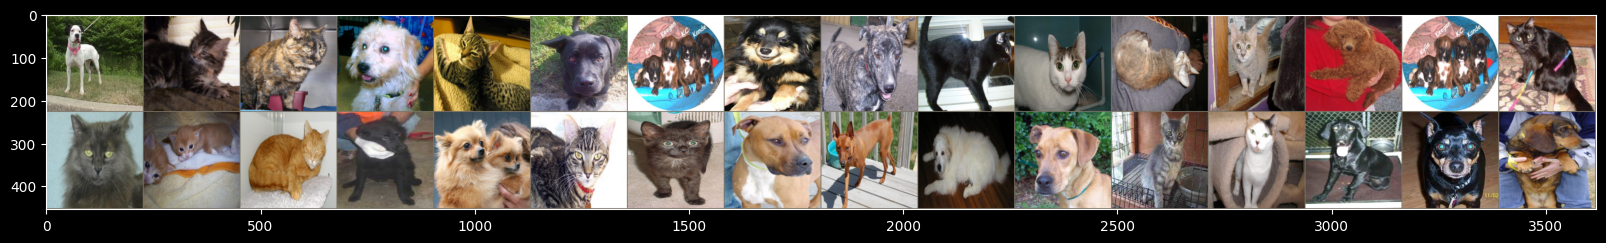

In [17]:
inv_normalize = transforms.Normalize(
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)
plt.figure(figsize=(20,16))
plt.imshow(np.transpose((im_inv.numpy()*255).astype(np.uint8),(1,2,0)))

In [22]:

resnet = torchvision.models.resnet18(weights = "ResNet18_Weights.DEFAULT")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


In [23]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
summary(resnet.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [25]:
for p in resnet.parameters():
  p.requires_grad = False

In [26]:
resnet.fc = nn.Linear(512, 2)

In [27]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
epochs = 6

lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), momentum=0.9, lr=0.001)


losses = torch.zeros(epochs)
trainAcc =[]
testAcc = []

for epoch in range(epochs):
  resnet.train()
  resnet.to(device)
  batchAcc = []
  batchLoss = []
  for X, y in train_loader:
    X, y =X.to(device), y.to(device)

    ypred = resnet(X)
    loss= lossfunc(ypred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batchLoss.append(loss.item())

    ypred = ypred.cpu()
    y=y.cpu()

    acc = 100*torch.mean((torch.argmax(ypred, dim=1)==y).float())
    batchAcc.append(acc)

  trainAcc.append(np.mean(batchAcc))
  losses[epoch] = np.mean(batchLoss)

  resnet.eval()
  X, y = next(iter(test_loader))
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    ypred = resnet(X)
    ypred = ypred.cpu()
    y=y.cpu()
    acc = 100*torch.mean((torch.argmax(ypred, dim=1)==y).float())
    testAcc.append(acc)
    print(f'epochs: {epoch} loss: {loss: 2.2f}')



epochs: 0 loss:  0.13
epochs: 1 loss:  0.06
epochs: 2 loss:  0.13
epochs: 3 loss:  0.07
epochs: 4 loss:  0.07
epochs: 5 loss:  0.13


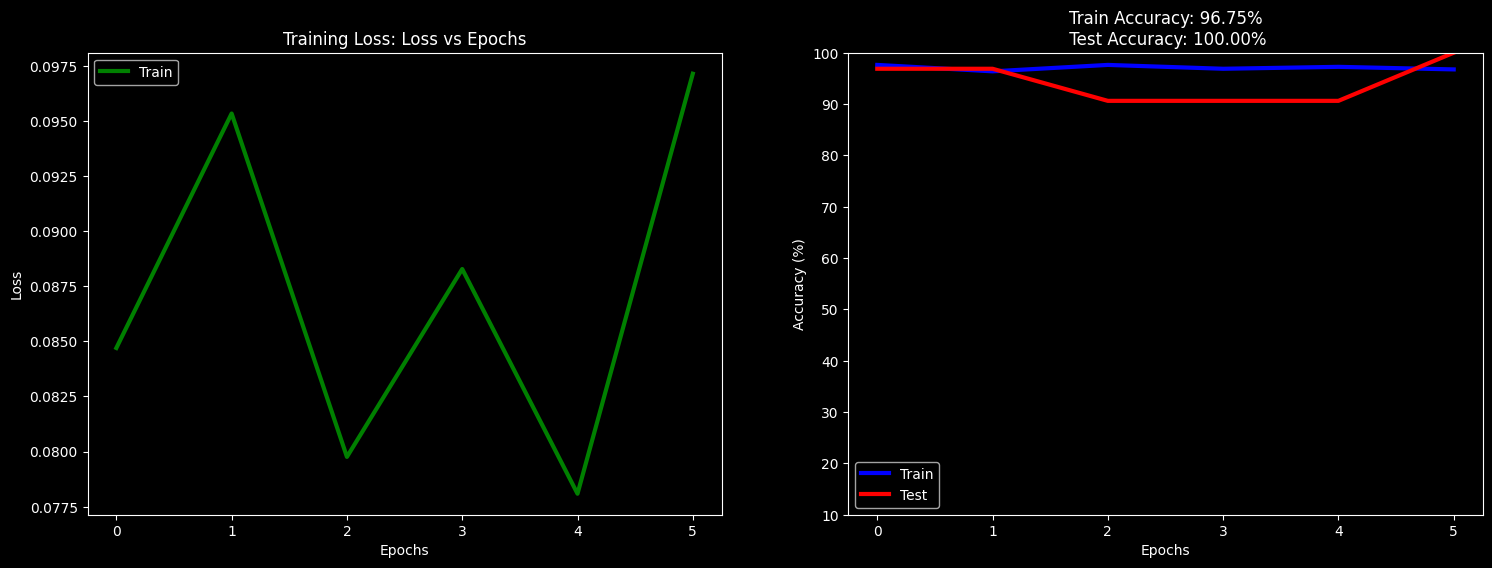

In [30]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw=3, label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss: Loss vs Epochs')
ax[0].legend()

ax[1].plot(trainAcc,'b', lw=3, label='Train')
ax[1].plot(testAcc,'r', lw=3, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title('Training Accuracy: Accuracy vs Epochs')
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}%\n Test Accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()